#pivot calculator

Analyzing E-mini Nasdaq-100 Futures...
Fetching NQ futures settlement data from CME Group...
Settlement table not found on the webpage.
Using generic NQ symbol as CME data could not be retrieved.

Analyzing NQ=F contract...


,symbol,date,prev_close,pivot,r1,r2,r3,s1,s2,s3
0,NQ=F,2025-03-27,20055.75,20063.75,20190.25,20324.75,20585.75,19929.25,19802.75,19541.75



Camarilla Levels:


,symbol,h4,h3,l3,l4
0,NQ=F,20342.85,20199.3,19912.2,19768.65


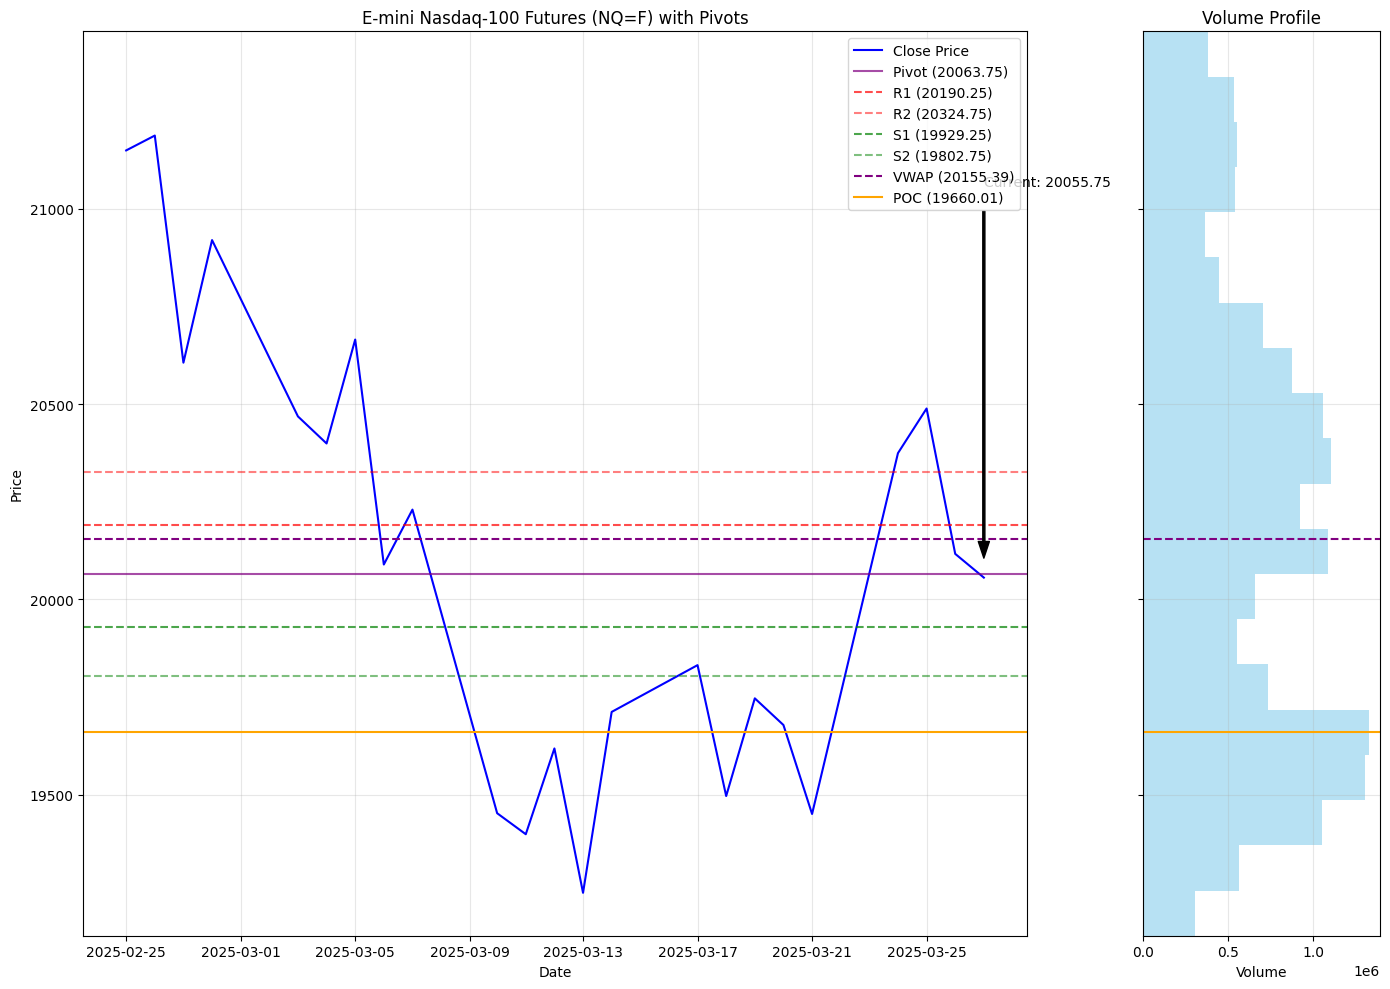

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

def get_nq_settlement_data():
    """
    Scrape settlement data for NQ futures from CME Group website
    """
    url = "https://www.cmegroup.com/markets/equities/nasdaq/e-mini-nasdaq-100.settlements.html"
    
    print(f"Fetching NQ futures settlement data from CME Group...")
    
    try:
        # Send request to the CME Group website
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the settlement table
        table = soup.find('table', {'class': 'settlements-data-table'})
        
        if not table:
            print("Settlement table not found on the webpage.")
            return None
        
        # Extract table headers
        headers = []
        header_row = table.find('thead').find('tr')
        for th in header_row.find_all('th'):
            headers.append(th.text.strip())
        
        # Extract table data
        data = []
        tbody = table.find('tbody')
        
        if tbody:
            for tr in tbody.find_all('tr'):
                row = []
                for td in tr.find_all('td'):
                    row.append(td.text.strip())
                if row:
                    data.append(row)
        
        # Create DataFrame
        df = pd.DataFrame(data, columns=headers)
        
        # Clean up and convert data types
        if 'Volume' in df.columns:
            df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
        
        if 'Settlement' in df.columns:
            df['Settlement'] = df['Settlement'].str.replace(',', '').astype(float)
        
        if 'Open Interest' in df.columns:
            df['Open Interest'] = df['Open Interest'].str.replace(',', '').astype(float)
        
        # Sort by open interest to find the contract with highest OI
        if 'Open Interest' in df.columns:
            df = df.sort_values('Open Interest', ascending=False).reset_index(drop=True)
        
        return df
    
    except Exception as e:
        print(f"Error fetching CME data: {e}")
        return None

def calculate_floor_pivots(ticker_symbol="NQ=F", lookback=20):
    """
    Calculate floor pivot points for NQ futures
    """
    # Get historical data
    ticker = yf.Ticker(ticker_symbol)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback+10)  # Add some buffer
    
    df = ticker.history(start=start_date, end=end_date)
    
    if df.empty:
        return None
    
    # Keep only the last 'lookback' days
    df = df.tail(lookback)
    
    # Most recent complete day
    prev_high = df['High'].iloc[-1]
    prev_low = df['Low'].iloc[-1]
    prev_close = df['Close'].iloc[-1]
    
    # Calculate floor pivot points
    pivot = (prev_high + prev_low + prev_close) / 3
    
    # Support levels
    s1 = (2 * pivot) - prev_high
    s2 = pivot - (prev_high - prev_low)
    s3 = s2 - (prev_high - prev_low)
    
    # Resistance levels
    r1 = (2 * pivot) - prev_low
    r2 = pivot + (prev_high - prev_low)
    r3 = r2 + (prev_high - prev_low)
    
    # Calculate Camarilla levels (additional precision pivots)
    h4 = prev_close + (prev_high - prev_low) * 1.1
    h3 = prev_close + (prev_high - prev_low) * 1.1/2
    l3 = prev_close - (prev_high - prev_low) * 1.1/2
    l4 = prev_close - (prev_high - prev_low) * 1.1
    
    # Calculate Fibonacci retracement levels
    range_hl = prev_high - prev_low
    fib_38 = prev_high - (0.382 * range_hl)
    fib_50 = prev_high - (0.5 * range_hl)
    fib_62 = prev_high - (0.618 * range_hl)
    
    # Create result dictionary
    pivot_data = {
        'symbol': ticker_symbol,
        'date': df.index[-1].strftime('%Y-%m-%d'),
        'prev_close': prev_close,
        'prev_high': prev_high,
        'prev_low': prev_low,
        'pivot': pivot,
        'r3': r3,
        'r2': r2,
        'r1': r1,
        's1': s1,
        's2': s2,
        's3': s3,
        'h4': h4,
        'h3': h3,
        'l3': l3,
        'l4': l4,
        'fib_38': fib_38,
        'fib_50': fib_50,
        'fib_62': fib_62
    }
    
    return pivot_data

def get_nq_active_month_symbol(settlement_df):
    """
    Determine the most active NQ futures contract symbol
    """
    if settlement_df is None or settlement_df.empty:
        # Default to the front-month contract if we couldn't get settlement data
        return "NQ=F"
    
    # Get the month code from the contract with highest open interest
    try:
        # The contract month should be in the first column
        contract_month = settlement_df.iloc[0, 0]
        
        # Extract month code (if possible)
        month_codes = {"JAN": "F", "FEB": "G", "MAR": "H", "APR": "J", 
                      "MAY": "K", "JUN": "M", "JUL": "N", "AUG": "Q", 
                      "SEP": "U", "OCT": "V", "NOV": "X", "DEC": "Z"}
        
        for month_name, code in month_codes.items():
            if month_name in contract_month.upper():
                year = contract_month[-2:]  # Last two digits of year
                return f"NQ{code}{year}.CME"
    except:
        pass
    
    # Fallback to generic symbol
    return "NQ=F"

def plot_price_with_pivots(ticker_symbol, pivot_data, days=60):
    """
    Plot price chart with pivot levels for NQ futures
    """
    # Get more historical data for the chart
    ticker = yf.Ticker(ticker_symbol)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    df = ticker.history(start=start_date, end=end_date)
    
    if df.empty:
        return None
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Plot price
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    
    # Current price
    current_price = df['Close'].iloc[-1]
    
    # Plot pivot level
    pivot_level = pivot_data['pivot']
    plt.axhline(y=pivot_level, color='purple', linestyle='-', alpha=0.7, label=f'Pivot ({pivot_level:.2f})')
    
    # Plot resistance levels
    plt.axhline(y=pivot_data['r1'], color='red', linestyle='--', alpha=0.7, label=f'R1 ({pivot_data["r1"]:.2f})')
    plt.axhline(y=pivot_data['r2'], color='red', linestyle='--', alpha=0.5, label=f'R2 ({pivot_data["r2"]:.2f})')
    plt.axhline(y=pivot_data['r3'], color='red', linestyle='--', alpha=0.3, label=f'R3 ({pivot_data["r3"]:.2f})')
    
    # Plot support levels
    plt.axhline(y=pivot_data['s1'], color='green', linestyle='--', alpha=0.7, label=f'S1 ({pivot_data["s1"]:.2f})')
    plt.axhline(y=pivot_data['s2'], color='green', linestyle='--', alpha=0.5, label=f'S2 ({pivot_data["s2"]:.2f})')
    plt.axhline(y=pivot_data['s3'], color='green', linestyle='--', alpha=0.3, label=f'S3 ({pivot_data["s3"]:.2f})')
    
    # Plot Camarilla levels
    plt.axhline(y=pivot_data['h4'], color='orange', linestyle=':', alpha=0.5, label=f'H4 ({pivot_data["h4"]:.2f})')
    plt.axhline(y=pivot_data['h3'], color='orange', linestyle=':', alpha=0.7, label=f'H3 ({pivot_data["h3"]:.2f})')
    plt.axhline(y=pivot_data['l3'], color='green', linestyle=':', alpha=0.7, label=f'L3 ({pivot_data["l3"]:.2f})')
    plt.axhline(y=pivot_data['l4'], color='green', linestyle=':', alpha=0.5, label=f'L4 ({pivot_data["l4"]:.2f})')
    
    # Add labels and title
    plt.title(f'E-mini Nasdaq-100 Futures ({ticker_symbol}) with Floor Pivots')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Add current price annotation
    plt.annotate(f'Current: {current_price:.2f}', 
                 xy=(df.index[-1], current_price),
                 xytext=(df.index[-1], current_price*1.05),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                 fontsize=12)
    
    plt.tight_layout()
    return plt

def analyze_nq_volume_profile(ticker_symbol="NQ=F", days=30):
    """
    Analyze volume profile for NQ futures
    """
    # Get historical data
    ticker = yf.Ticker(ticker_symbol)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    df = ticker.history(start=start_date, end=end_date)
    
    if df.empty:
        return None
    
    # Create price bins for volume distribution
    price_range = df['High'].max() - df['Low'].min()
    bin_size = price_range / 20  # 20 price bins
    
    bins = np.arange(df['Low'].min(), df['High'].max() + bin_size, bin_size)
    
    # Initialize volume by price
    volume_by_price = np.zeros(len(bins) - 1)
    
    # Calculate volume per price level
    for i in range(len(df)):
        high = df['High'].iloc[i]
        low = df['Low'].iloc[i]
        volume = df['Volume'].iloc[i]
        
        # Distribute volume across price range for the day
        for j in range(len(bins) - 1):
            if bins[j+1] >= low and bins[j] <= high:
                # Calculate overlap between price bin and day's range
                overlap_bottom = max(bins[j], low)
                overlap_top = min(bins[j+1], high)
                overlap = (overlap_top - overlap_bottom) / (high - low)
                
                # Assign proportional volume to this price bin
                volume_by_price[j] += volume * overlap
    
    # Calculate VWAP
    vwap = np.sum(df['Close'] * df['Volume']) / np.sum(df['Volume'])
    
    # Find price level with highest volume (POC - Point of Control)
    poc_index = np.argmax(volume_by_price)
    poc_price = (bins[poc_index] + bins[poc_index + 1]) / 2
    
    return {
        'vwap': vwap,
        'poc': poc_price,
        'volume_by_price': volume_by_price,
        'price_bins': bins
    }

def plot_volume_profile(ticker_symbol, volume_data, pivot_data):
    """
    Plot volume profile along with price
    """
    # Get recent price data
    ticker = yf.Ticker(ticker_symbol)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    
    df = ticker.history(start=start_date, end=end_date)
    
    if df.empty or volume_data is None:
        return None
    
    # Create figure with subplots (price on top, volume profile on right)
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(1, 4)
    ax1 = fig.add_subplot(gs[0, :3])  # Price chart
    ax2 = fig.add_subplot(gs[0, 3])   # Volume profile
    
    # Plot price
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    
    # Plot pivot levels on price chart
    pivot_level = pivot_data['pivot']
    ax1.axhline(y=pivot_level, color='purple', linestyle='-', alpha=0.7, label=f'Pivot ({pivot_level:.2f})')
    
    # Plot resistance levels
    ax1.axhline(y=pivot_data['r1'], color='red', linestyle='--', alpha=0.7, label=f'R1 ({pivot_data["r1"]:.2f})')
    ax1.axhline(y=pivot_data['r2'], color='red', linestyle='--', alpha=0.5, label=f'R2 ({pivot_data["r2"]:.2f})')
    
    # Plot support levels
    ax1.axhline(y=pivot_data['s1'], color='green', linestyle='--', alpha=0.7, label=f'S1 ({pivot_data["s1"]:.2f})')
    ax1.axhline(y=pivot_data['s2'], color='green', linestyle='--', alpha=0.5, label=f'S2 ({pivot_data["s2"]:.2f})')
    
    # Volume profile
    bins = volume_data['price_bins']
    volumes = volume_data['volume_by_price']
    bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    
    ax2.barh(bin_centers, volumes, height=bins[1]-bins[0], alpha=0.6, color='skyblue')
    
    # Add VWAP line to both charts
    vwap = volume_data['vwap']
    ax1.axhline(y=vwap, color='purple', linestyle='--', label=f'VWAP ({vwap:.2f})')
    ax2.axhline(y=vwap, color='purple', linestyle='--')
    
    # Add POC line to both charts
    poc = volume_data['poc']
    ax1.axhline(y=poc, color='orange', linestyle='-', label=f'POC ({poc:.2f})')
    ax2.axhline(y=poc, color='orange', linestyle='-')
    
    # Add current price to price chart
    current_price = df['Close'].iloc[-1]
    ax1.annotate(f'Current: {current_price:.2f}', 
                xy=(df.index[-1], current_price),
                xytext=(df.index[-1], current_price*1.05),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)
    
    # Chart formatting
    ax1.set_title(f'E-mini Nasdaq-100 Futures ({ticker_symbol}) with Pivots')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    ax2.set_title('Volume Profile')
    ax2.set_xlabel('Volume')
    ax2.set_yticklabels([])
    ax2.grid(True, alpha=0.3)
    
    # Align y-axis between price chart and volume profile
    ax1.set_ylim(min(bins), max(bins))
    ax2.set_ylim(min(bins), max(bins))
    
    plt.tight_layout()
    return plt

# Main execution
def main():
    print("Analyzing E-mini Nasdaq-100 Futures...")
    
    # Get settlement data from CME Group
    settlement_df = get_nq_settlement_data()
    
    if settlement_df is not None and not settlement_df.empty:
        print("\nCME Group Settlement Data for NQ Futures:")
        display(settlement_df.head(10))
        
        # Get the symbol for the most active contract
        nq_symbol = get_nq_active_month_symbol(settlement_df)
    else:
        print("Using generic NQ symbol as CME data could not be retrieved.")
        nq_symbol = "NQ=F"
    
    print(f"\nAnalyzing {nq_symbol} contract...")
    
    # Calculate pivot points
    pivot_data = calculate_floor_pivots(nq_symbol)
    
    if pivot_data is None:
        print(f"Could not retrieve data for {nq_symbol}")
        return
    
    # Display pivot points
    pivot_df = pd.DataFrame([pivot_data])
    cols_to_display = ['symbol', 'date', 'prev_close', 'pivot', 'r1', 'r2', 'r3', 's1', 's2', 's3']
    display(pivot_df[cols_to_display])
    
    # Display Camarilla levels
    camarilla_df = pivot_df[['symbol', 'h4', 'h3', 'l3', 'l4']]
    print("\nCamarilla Levels:")
    display(camarilla_df)
    
    # Calculate volume profile
    volume_data = analyze_nq_volume_profile(nq_symbol)
    
    # Plot price with pivot levels and volume profile
    if volume_data:
        plot = plot_volume_profile(nq_symbol, volume_data, pivot_data)
    else:
        plot = plot_price_with_pivots(nq_symbol, pivot_data)
    
    if plot:
        plt.show()
    
# Run the main function
if __name__ == "__main__":
    main()